In [221]:
import pickle
import glob
import torch
import numpy as np
import seaborn as sns

In [222]:
# Antonio - Unibo

output_dir = "/home/aguastella/fl_powerpropagation/outputs/"
day = "2024-09-29"
time = "08-50-34"
global_masks_dir = "/working/global_masks"


# lr0.5
# lda0.1
day = "2024-09-29"
time = "08-50-34"  # zerofl cifar10 s0.95
time = "10-27-45"  # topk cifar10 s0.95
time = "11-20-18"  # pp cifar100 s0.95
time = "12-19-22"  # zerofl cifar100 s0.9
time = "13-58-20"  # topk cifar100 s0.9

time = "14-51-35"  # pp cifar10 s0.9
time = "16-02-43"  # pp cifar10 s0.95
time = "17-01-47"  # zerfl cifar10 s0.9
time = "18-40-46"  # pp cifar100 s0.9
time = "19-40-30"  # zerofl cifar100 s0.95

time = "13-58-20"  # topk cifar100 s0.95
time = "13-58-20"  # topk cifar100 s0.9


# directory_path =  "/home/aguastella/fl_powerpropagation/outputs/2024-09-29/08-50-34/working/global_masks" # zerofl cifar10
# directory_path =  "/home/aguastella/fl_powerpropagation/outputs/2024-09-29/10-27-45/working/global_masks" # topk cifar10
# directory_path =  "/home/aguastella/fl_powerpropagation/outputs/2024-09-29/11-20-18/working/global_masks" # pp cifar100
# directory_path =  "/home/aguastella/fl_powerpropagation/outputs/2024-09-29/12-19-22/working/global_masks" # zerofl cifar100
directory_path = output_dir + day + "/" + time + global_masks_dir

In [ ]:
pp_cifar10_s095 = "16-02-43"  # pp cifar10 s0.95
topk_cifar10_s095 = "10-27-45"  # topk cifar10 s0.95
zerofl_cifar10_s095 = "08-50-34"  # zerofl cifar10 s0.95

pp_cifar10_s09 = "14-51-35"  # pp cifar10 s0.9
zerofl_cifar10_s09 = "17-01-47"  # zerfl cifar10 s0.9

pp_cifar100_s095 = "11-20-18"  # pp cifar100 s0.95
zerofl_cifar100_s095 = "19-40-30"  # zerofl cifar100 s0.95

pp_cifar100_s09 = "18-40-46"  # pp cifar100 s0.9
topk_cifar100_s09 = "13-58-20"  # topk cifar100 s0.9
zerofl_cifar100_s09 = "12-19-22"  # zerofl cifar100 s0.9

In [223]:
# zeph
# directory_path = "/home/zep/fl_powerpropagation/outputs/2024-07-29/17-28-42/working" # top-k
# directory_path = "/home/zep/fl_powerpropagation/outputs/2024-07-29/17-28-42/working/client_masks" # top-k
# directory_path = "/home/zep/fl_powerpropagation/outputs/2024-07-29/18-23-34/working" # top-k
# directory_path = "/home/zep/fl_powerpropagation/outputs/2024-07-29/18-23-34/working/client_masks" # top-k


# directory_path = "/home/zep/fl_powerpropagation/outputs/2024-07-29/18-02-37/working" # pp
# directory_path = "/home/zep/fl_powerpropagation/outputs/2024-07-29/18-02-37/working/client_masks" # pp

In [224]:
# Utils
import re


sampling_rate = 10


def extract_numbers(filename):
    match = re.search(r"mask_(\d+)_client_(\d+)", filename)
    if match:
        mask_num = int(match.group(1))
        client_num = int(match.group(2))
        return mask_num, client_num
    return None, None


# Get a list of all pickle files
pickle_files = glob.glob(f"{directory_path}/mask_*.pickle")
print(pickle_files)
# sort by name
pickle_files.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
# pickle_files = sorted(pickle_files, key=lambda x: extract_numbers(x))
# pickle_files = (glob.glob(f"{directory_path}/mask_*.pickle"))
print(pickle_files)
# pickle_files.pop(0)
# pickle_files.pop(1)
# keep only the first 300
# pickle_files = pickle_files[:10]


# keep only one overy 10
# pickle_files = pickle_files[::sampling_rate]


# Load the masks
masks = []
for file in pickle_files:
    with open(file, "rb") as f:
        mask = pickle.load(f)
        masks.append(mask)


# Ensure each mask is a list of numpy arrays
# masks = [[np.array(layer_mask) for layer_mask in mask] for mask in masks]

['/home/aguastella/fl_powerpropagation/outputs/2024-09-29/13-58-20/working/global_masks/mask_40.pickle', '/home/aguastella/fl_powerpropagation/outputs/2024-09-29/13-58-20/working/global_masks/mask_150.pickle', '/home/aguastella/fl_powerpropagation/outputs/2024-09-29/13-58-20/working/global_masks/mask_200.pickle', '/home/aguastella/fl_powerpropagation/outputs/2024-09-29/13-58-20/working/global_masks/mask_130.pickle', '/home/aguastella/fl_powerpropagation/outputs/2024-09-29/13-58-20/working/global_masks/mask_60.pickle', '/home/aguastella/fl_powerpropagation/outputs/2024-09-29/13-58-20/working/global_masks/mask_180.pickle', '/home/aguastella/fl_powerpropagation/outputs/2024-09-29/13-58-20/working/global_masks/mask_30.pickle', '/home/aguastella/fl_powerpropagation/outputs/2024-09-29/13-58-20/working/global_masks/mask_190.pickle', '/home/aguastella/fl_powerpropagation/outputs/2024-09-29/13-58-20/working/global_masks/mask_100.pickle', '/home/aguastella/fl_powerpropagation/outputs/2024-09-29/

Reordering layer of the mask

In [225]:
# Assume original_ordered_keys and sorted_ordered_keys are given
original_ordered_keys = {
    0: "net.conv1.weight",
    1: "net.bn1.weight",
    2: "net.bn1.bias",
    3: "net.bn1.running_mean",
    4: "net.bn1.running_var",
    5: "net.bn1.num_batches_tracked",
    6: "net.layer1.0.conv1.weight",
    7: "net.layer1.0.bn1.weight",
    8: "net.layer1.0.bn1.bias",
    9: "net.layer1.0.bn1.running_mean",
    10: "net.layer1.0.bn1.running_var",
    11: "net.layer1.0.bn1.num_batches_tracked",
    12: "net.layer1.0.conv2.weight",
    13: "net.layer1.0.bn2.weight",
    14: "net.layer1.0.bn2.bias",
    15: "net.layer1.0.bn2.running_mean",
    16: "net.layer1.0.bn2.running_var",
    17: "net.layer1.0.bn2.num_batches_tracked",
    18: "net.layer1.1.conv1.weight",
    19: "net.layer1.1.bn1.weight",
    20: "net.layer1.1.bn1.bias",
    21: "net.layer1.1.bn1.running_mean",
    22: "net.layer1.1.bn1.running_var",
    23: "net.layer1.1.bn1.num_batches_tracked",
    24: "net.layer1.1.conv2.weight",
    25: "net.layer1.1.bn2.weight",
    26: "net.layer1.1.bn2.bias",
    27: "net.layer1.1.bn2.running_mean",
    28: "net.layer1.1.bn2.running_var",
    29: "net.layer1.1.bn2.num_batches_tracked",
    30: "net.layer2.0.conv1.weight",
    31: "net.layer2.0.bn1.weight",
    32: "net.layer2.0.bn1.bias",
    33: "net.layer2.0.bn1.running_mean",
    34: "net.layer2.0.bn1.running_var",
    35: "net.layer2.0.bn1.num_batches_tracked",
    36: "net.layer2.0.conv2.weight",
    37: "net.layer2.0.bn2.weight",
    38: "net.layer2.0.bn2.bias",
    39: "net.layer2.0.bn2.running_mean",
    40: "net.layer2.0.bn2.running_var",
    41: "net.layer2.0.bn2.num_batches_tracked",
    42: "net.layer2.0.downsample.0.weight",
    43: "net.layer2.0.downsample.1.weight",
    44: "net.layer2.0.downsample.1.bias",
    45: "net.layer2.0.downsample.1.running_mean",
    46: "net.layer2.0.downsample.1.running_var",
    47: "net.layer2.0.downsample.1.num_batches_tracked",
    48: "net.layer2.1.conv1.weight",
    49: "net.layer2.1.bn1.weight",
    50: "net.layer2.1.bn1.bias",
    51: "net.layer2.1.bn1.running_mean",
    52: "net.layer2.1.bn1.running_var",
    53: "net.layer2.1.bn1.num_batches_tracked",
    54: "net.layer2.1.conv2.weight",
    55: "net.layer2.1.bn2.weight",
    56: "net.layer2.1.bn2.bias",
    57: "net.layer2.1.bn2.running_mean",
    58: "net.layer2.1.bn2.running_var",
    59: "net.layer2.1.bn2.num_batches_tracked",
    60: "net.layer3.0.conv1.weight",
    61: "net.layer3.0.bn1.weight",
    62: "net.layer3.0.bn1.bias",
    63: "net.layer3.0.bn1.running_mean",
    64: "net.layer3.0.bn1.running_var",
    65: "net.layer3.0.bn1.num_batches_tracked",
    66: "net.layer3.0.conv2.weight",
    67: "net.layer3.0.bn2.weight",
    68: "net.layer3.0.bn2.bias",
    69: "net.layer3.0.bn2.running_mean",
    70: "net.layer3.0.bn2.running_var",
    71: "net.layer3.0.bn2.num_batches_tracked",
    72: "net.layer3.0.downsample.0.weight",
    73: "net.layer3.0.downsample.1.weight",
    74: "net.layer3.0.downsample.1.bias",
    75: "net.layer3.0.downsample.1.running_mean",
    76: "net.layer3.0.downsample.1.running_var",
    77: "net.layer3.0.downsample.1.num_batches_tracked",
    78: "net.layer3.1.conv1.weight",
    79: "net.layer3.1.bn1.weight",
    80: "net.layer3.1.bn1.bias",
    81: "net.layer3.1.bn1.running_mean",
    82: "net.layer3.1.bn1.running_var",
    83: "net.layer3.1.bn1.num_batches_tracked",
    84: "net.layer3.1.conv2.weight",
    85: "net.layer3.1.bn2.weight",
    86: "net.layer3.1.bn2.bias",
    87: "net.layer3.1.bn2.running_mean",
    88: "net.layer3.1.bn2.running_var",
    89: "net.layer3.1.bn2.num_batches_tracked",
    90: "net.layer4.0.conv1.weight",
    91: "net.layer4.0.bn1.weight",
    92: "net.layer4.0.bn1.bias",
    93: "net.layer4.0.bn1.running_mean",
    94: "net.layer4.0.bn1.running_var",
    95: "net.layer4.0.bn1.num_batches_tracked",
    96: "net.layer4.0.conv2.weight",
    97: "net.layer4.0.bn2.weight",
    98: "net.layer4.0.bn2.bias",
    99: "net.layer4.0.bn2.running_mean",
    100: "net.layer4.0.bn2.running_var",
    101: "net.layer4.0.bn2.num_batches_tracked",
    102: "net.layer4.0.downsample.0.weight",
    103: "net.layer4.0.downsample.1.weight",
    104: "net.layer4.0.downsample.1.bias",
    105: "net.layer4.0.downsample.1.running_mean",
    106: "net.layer4.0.downsample.1.running_var",
    107: "net.layer4.0.downsample.1.num_batches_tracked",
    108: "net.layer4.1.conv1.weight",
    109: "net.layer4.1.bn1.weight",
    110: "net.layer4.1.bn1.bias",
    111: "net.layer4.1.bn1.running_mean",
    112: "net.layer4.1.bn1.running_var",
    113: "net.layer4.1.bn1.num_batches_tracked",
    114: "net.layer4.1.conv2.weight",
    115: "net.layer4.1.bn2.weight",
    116: "net.layer4.1.bn2.bias",
    117: "net.layer4.1.bn2.running_mean",
    118: "net.layer4.1.bn2.running_var",
    119: "net.layer4.1.bn2.num_batches_tracked",
    120: "net.fc.weight",
    121: "net.fc.bias",
}
sorted_ordered_keys = {
    0: "net.bn1.bias",
    1: "net.bn1.num_batches_tracked",
    2: "net.bn1.running_mean",
    3: "net.bn1.running_var",
    4: "net.bn1.weight",
    5: "net.conv1.weight",
    6: "net.fc.bias",
    7: "net.fc.weight",
    8: "net.layer1.0.bn1.bias",
    9: "net.layer1.0.bn1.num_batches_tracked",
    10: "net.layer1.0.bn1.running_mean",
    11: "net.layer1.0.bn1.running_var",
    12: "net.layer1.0.bn1.weight",
    13: "net.layer1.0.bn2.bias",
    14: "net.layer1.0.bn2.num_batches_tracked",
    15: "net.layer1.0.bn2.running_mean",
    16: "net.layer1.0.bn2.running_var",
    17: "net.layer1.0.bn2.weight",
    18: "net.layer1.0.conv1.weight",
    19: "net.layer1.0.conv2.weight",
    20: "net.layer1.1.bn1.bias",
    21: "net.layer1.1.bn1.num_batches_tracked",
    22: "net.layer1.1.bn1.running_mean",
    23: "net.layer1.1.bn1.running_var",
    24: "net.layer1.1.bn1.weight",
    25: "net.layer1.1.bn2.bias",
    26: "net.layer1.1.bn2.num_batches_tracked",
    27: "net.layer1.1.bn2.running_mean",
    28: "net.layer1.1.bn2.running_var",
    29: "net.layer1.1.bn2.weight",
    30: "net.layer1.1.conv1.weight",
    31: "net.layer1.1.conv2.weight",
    32: "net.layer2.0.bn1.bias",
    33: "net.layer2.0.bn1.num_batches_tracked",
    34: "net.layer2.0.bn1.running_mean",
    35: "net.layer2.0.bn1.running_var",
    36: "net.layer2.0.bn1.weight",
    37: "net.layer2.0.bn2.bias",
    38: "net.layer2.0.bn2.num_batches_tracked",
    39: "net.layer2.0.bn2.running_mean",
    40: "net.layer2.0.bn2.running_var",
    41: "net.layer2.0.bn2.weight",
    42: "net.layer2.0.conv1.weight",
    43: "net.layer2.0.conv2.weight",
    44: "net.layer2.0.downsample.0.weight",
    45: "net.layer2.0.downsample.1.bias",
    46: "net.layer2.0.downsample.1.num_batches_tracked",
    47: "net.layer2.0.downsample.1.running_mean",
    48: "net.layer2.0.downsample.1.running_var",
    49: "net.layer2.0.downsample.1.weight",
    50: "net.layer2.1.bn1.bias",
    51: "net.layer2.1.bn1.num_batches_tracked",
    52: "net.layer2.1.bn1.running_mean",
    53: "net.layer2.1.bn1.running_var",
    54: "net.layer2.1.bn1.weight",
    55: "net.layer2.1.bn2.bias",
    56: "net.layer2.1.bn2.num_batches_tracked",
    57: "net.layer2.1.bn2.running_mean",
    58: "net.layer2.1.bn2.running_var",
    59: "net.layer2.1.bn2.weight",
    60: "net.layer2.1.conv1.weight",
    61: "net.layer2.1.conv2.weight",
    62: "net.layer3.0.bn1.bias",
    63: "net.layer3.0.bn1.num_batches_tracked",
    64: "net.layer3.0.bn1.running_mean",
    65: "net.layer3.0.bn1.running_var",
    66: "net.layer3.0.bn1.weight",
    67: "net.layer3.0.bn2.bias",
    68: "net.layer3.0.bn2.num_batches_tracked",
    69: "net.layer3.0.bn2.running_mean",
    70: "net.layer3.0.bn2.running_var",
    71: "net.layer3.0.bn2.weight",
    72: "net.layer3.0.conv1.weight",
    73: "net.layer3.0.conv2.weight",
    74: "net.layer3.0.downsample.0.weight",
    75: "net.layer3.0.downsample.1.bias",
    76: "net.layer3.0.downsample.1.num_batches_tracked",
    77: "net.layer3.0.downsample.1.running_mean",
    78: "net.layer3.0.downsample.1.running_var",
    79: "net.layer3.0.downsample.1.weight",
    80: "net.layer3.1.bn1.bias",
    81: "net.layer3.1.bn1.num_batches_tracked",
    82: "net.layer3.1.bn1.running_mean",
    83: "net.layer3.1.bn1.running_var",
    84: "net.layer3.1.bn1.weight",
    85: "net.layer3.1.bn2.bias",
    86: "net.layer3.1.bn2.num_batches_tracked",
    87: "net.layer3.1.bn2.running_mean",
    88: "net.layer3.1.bn2.running_var",
    89: "net.layer3.1.bn2.weight",
    90: "net.layer3.1.conv1.weight",
    91: "net.layer3.1.conv2.weight",
    92: "net.layer4.0.bn1.bias",
    93: "net.layer4.0.bn1.num_batches_tracked",
    94: "net.layer4.0.bn1.running_mean",
    95: "net.layer4.0.bn1.running_var",
    96: "net.layer4.0.bn1.weight",
    97: "net.layer4.0.bn2.bias",
    98: "net.layer4.0.bn2.num_batches_tracked",
    99: "net.layer4.0.bn2.running_mean",
    100: "net.layer4.0.bn2.running_var",
    101: "net.layer4.0.bn2.weight",
    102: "net.layer4.0.conv1.weight",
    103: "net.layer4.0.conv2.weight",
    104: "net.layer4.0.downsample.0.weight",
    105: "net.layer4.0.downsample.1.bias",
    106: "net.layer4.0.downsample.1.num_batches_tracked",
    107: "net.layer4.0.downsample.1.running_mean",
    108: "net.layer4.0.downsample.1.running_var",
    109: "net.layer4.0.downsample.1.weight",
    110: "net.layer4.1.bn1.bias",
    111: "net.layer4.1.bn1.num_batches_tracked",
    112: "net.layer4.1.bn1.running_mean",
    113: "net.layer4.1.bn1.running_var",
    114: "net.layer4.1.bn1.weight",
    115: "net.layer4.1.bn2.bias",
    116: "net.layer4.1.bn2.num_batches_tracked",
    117: "net.layer4.1.bn2.running_mean",
    118: "net.layer4.1.bn2.running_var",
    119: "net.layer4.1.bn2.weight",
    120: "net.layer4.1.conv1.weight",
    121: "net.layer4.1.conv2.weight",
}

# Create a mapping from sorted order to original order
index_mapping = {v: k for k, v in original_ordered_keys.items()}
sorted_indices = [
    index_mapping[sorted_ordered_keys[i]] for i in range(len(sorted_ordered_keys))
]


# Function to reorder masks
def reorder_masks(mask_list):
    reordered_mask_list = []
    for round_masks in mask_list:
        reordered_masks = [None] * len(round_masks)
        for i, sorted_index in enumerate(sorted_indices):
            reordered_masks[sorted_index] = round_masks[i]
        reordered_mask_list.append(reordered_masks)
    return reordered_mask_list


masks = reorder_masks(masks)

# Printing the reordered masks for verification
# for i, round_masks in enumerate(reordered_masks):
#     print(f"Round {i+1} reordered masks:")
#     for j, mask in enumerate(round_masks):
#         print(f"Layer {j}: {mask}")

In [226]:
# for mask in masks:
#     for m in mask:
#         if m.shape != (10, ) and m.shape != (64, ) and m.shape != () and m.shape != (128,) and m.shape != (256,) and m.shape != (512,):
#             print(m.shape)
#             # print the type of mask
#     # print(len(mask))

In [227]:
# # Define the directory containing the .bin files
# directory_path = "/home/zep/fl_powerpropagation/outputs/2024-06-11/18-26-01/results/parameters"

# # Get a list of all .bin files
# bin_files = sorted(glob.glob(f"{directory_path}/parameters*.bin"))

# # Load the model parameters
# models = []
# for file in bin_files:
#     try:
#         # Attempt to load using torch.load
#         model_state = torch.load(file)
#         models.append(model_state)
#     except Exception as e:
#         print(f"Error loading {file}: {e}")

# # Convert model parameters to binary masks
# masks = []
# for model_state in models:
#     mask = [param != 0 for param in model_state.values()]
#     masks.append(mask)

In [228]:
# Ensure each mask is a list of numpy arrays
# masks = [[np.array(layer_mask) for layer_mask in mask] for mask in masks]

In [229]:
# Function to compute overlap percentage between two masks
# def compute_overlap_percentage(mask1, mask2):
#     total_weights = sum(m1.size for m1 in mask1)  # Total number of weights
#     overlap_weights = sum(
#         np.sum(m1 & m2) for m1, m2 in zip(mask1, mask2)
#     )  # Overlapping weights
#     return (overlap_weights / total_weights) * 100  # Percentage of overlap


def intersection_over_union(mask1, mask2):
    intersection = sum(np.sum(m1 & m2) for m1, m2 in zip(mask1, mask2))
    union = sum(np.sum(m1 | m2) for m1, m2 in zip(mask1, mask2))
    # print(intersection, union)
    return intersection / union


# Compute overlap percentage between consecutive masks
overlap_percentages = [
    intersection_over_union(masks[i], masks[i + 1]) for i in range(len(masks) - 1)
]

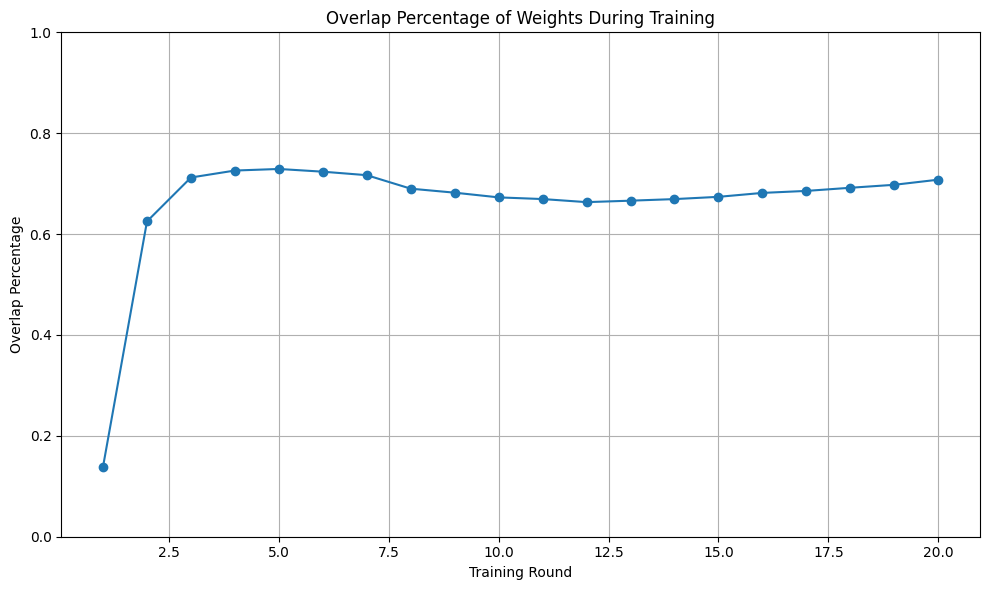

In [230]:
import matplotlib.pyplot as plt

# Plot overlap percentage over time
rounds = range(1, len(overlap_percentages) + 1)
plt.figure(figsize=(10, 6))
plt.plot(rounds, overlap_percentages, marker="o")
plt.xlabel("Training Round")
plt.ylabel("Overlap Percentage")
plt.title("Overlap Percentage of Weights During Training")
plt.grid(True)
plt.ylim(0, 1.0)  # Set the y-axis limits
plt.tight_layout()
plt.show()

In [231]:
import concurrent.futures


# Compute overlap percentage matrix
num_masks = len(masks)
overlap_matrix = np.zeros((num_masks, num_masks))
overlap_matrix_layer = np.zeros((len(masks[0]), num_masks, num_masks))


def compute_overlap(i, j):
    # overlap_matrix[i, j] = compute_overlap_percentage(masks[i], masks[j])
    overlap_matrix[i, j] = intersection_over_union(masks[i], masks[j])

    # for k in range(len(masks[0])):
    #     if masks[i][k].shape != (10, ) and masks[i][k].shape != (64, ) and masks[i][k].shape != () and masks[i][k].shape != (128,) and masks[i][k].shape != (256,) and masks[i][k].shape != (512,):
    #         overlap_matrix_layer[k, i, j] = intersection_over_union(masks[i][k], masks[j][k])


# Use multi-threading to parallelize the computation
# with concurrent.futures.ThreadPoolExecutor() as executor:
#     futures = []
#     for i in range(num_masks):
#         for j in range(num_masks):
#             futures.append(executor.submit(compute_overlap, i, j))
#     # Wait for all computations to complete
#     concurrent.futures.wait(futures)

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for i in range(num_masks):
        for j in range(i):
            futures.append(executor.submit(compute_overlap, i, j))
    # Wait for all computations to complete
    concurrent.futures.wait(futures)

# Set the diagonal to 1.0
np.fill_diagonal(overlap_matrix, 1.0)
for i in range(num_masks):
    for j in range(i):
        overlap_matrix[j, i] = overlap_matrix[i, j]


# Print the overlap matrix
print(overlap_matrix)

[[1.         0.13887904 0.129614   0.12631081 0.12908986 0.13059835
  0.13342326 0.13794384 0.14282605 0.14681813 0.15065214 0.15466763
  0.15700108 0.15892329 0.15988894 0.16158889 0.16101461 0.16129262
  0.16203912 0.15975394 0.15978146]
 [0.13887904 1.         0.62519006 0.62422892 0.61569074 0.60273859
  0.59116231 0.57147752 0.54975585 0.53281564 0.51538175 0.50051746
  0.48543455 0.47276617 0.46259124 0.45366803 0.44822504 0.44180788
  0.43538868 0.4326062  0.42746099]
 [0.129614   0.62519006 1.         0.71218854 0.6902465  0.67519958
  0.65392529 0.62676721 0.59947323 0.57835768 0.55657221 0.53654191
  0.51808947 0.50577732 0.49307262 0.48273807 0.47576234 0.46880982
  0.4621215  0.45947954 0.45367318]
 [0.12631081 0.62422892 0.71218854 1.         0.72599101 0.70693602
  0.68570754 0.65584319 0.62292491 0.59805931 0.57395514 0.55347974
  0.53595993 0.52209736 0.5095532  0.49827968 0.49126064 0.48404375
  0.47605823 0.47415724 0.46782593]
 [0.12908986 0.61569074 0.6902465  0.725

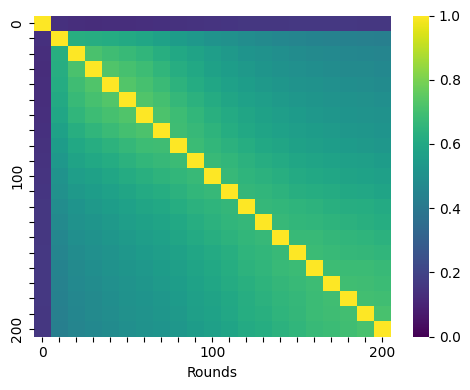

In [232]:
plt.figure(figsize=(5, 4))
sns.heatmap(
    overlap_matrix,
    annot=False,
    fmt=".2f",
    cmap="viridis",
    xticklabels=[
        label * sampling_rate if label % 10 == 0 else "" for label in range(num_masks)
    ],
    yticklabels=[
        label * sampling_rate if label % 10 == 0 else "" for label in range(num_masks)
    ],
    vmin=0,
    vmax=1.0,
)
plt.xlabel("Rounds")
# plt.ylabel("Rounds")
plt.tight_layout()
plt.show()

In [233]:
# import concurrent.futures
# import multiprocessing
# import numpy as np
# import ctypes
# from multiprocessing import sharedctypes


# def intersection_over_union(mask1, mask2):
#     # Dummy implementation
#     intersection = np.minimum(mask1, mask2).sum()
#     union = np.maximum(mask1, mask2).sum()
#     return intersection / union

# # Compute overlap percentage matrix
# num_masks = len(masks)
# overlap_matrix = np.zeros((num_masks, num_masks))

# # Create shared memory arrays
# shared_array_base = sharedctypes.RawArray(ctypes.c_double, num_masks * num_masks * len(masks[0]))
# overlap_matrix_layer = np.ctypeslib.as_array(shared_array_base)
# overlap_matrix_layer = overlap_matrix_layer.reshape(len(masks[0]), num_masks, num_masks)

# def compute_overlap_for_batch(batch, masks):
#     local_overlap_matrix_layer = np.zeros((len(masks[0]), num_masks, num_masks))
#     for i, j in batch:
#         for k in range(len(masks[0])):
#             if (
#                 masks[i][k].shape != (10,)
#                 and masks[i][k].shape != (64,)
#                 and masks[i][k].shape != ()
#                 and masks[i][k].shape != (128,)
#                 and masks[i][k].shape != (256,)
#                 and masks[i][k].shape != (512,)
#             ):
#                 local_overlap_matrix_layer[k, i, j] = intersection_over_union(
#                     masks[i][k], masks[j][k]
#                 )
#     return local_overlap_matrix_layer

# def parallel_computation(num_masks, masks, batch_size=10):
#     with concurrent.futures.ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
#         futures = []
#         # Create batches of (i, j) pairs
#         batches = [(i, j) for i in range(num_masks) for j in range(i)]
#         for batch_start in range(0, len(batches), batch_size):
#             batch = batches[batch_start:batch_start + batch_size]
#             futures.append(executor.submit(compute_overlap_for_batch, batch, masks))

#         for future in concurrent.futures.as_completed(futures):
#             local_overlap_matrix_layer = future.result()
#             overlap_matrix_layer += local_overlap_matrix_layer

#     # Set the diagonal of overlap_matrix_layer to 1.0
#     for k in range(len(masks[0])):
#         np.fill_diagonal(overlap_matrix_layer[k], 1.0)

#     # Fill the second half of the matrix
#     for i in range(num_masks):
#         for j in range(i):
#             overlap_matrix_layer[:, j, i] = overlap_matrix_layer[:, i, j]

#     return overlap_matrix_layer

# # Execute the parallel computation
# overlap_matrix_layer = parallel_computation(num_masks, masks)

In [234]:
import concurrent.futures
import multiprocessing

# if m.shape != (10, ) and m.shape != (64, ) and m.shape != () and m.shape != (128,) and m.shape != (256,) and m.shape != (512,):

# Compute overlap percentage matrix
num_masks = len(masks)
overlap_matrix = np.zeros((num_masks, num_masks))
overlap_matrix_layer = np.zeros((len(masks[0]), num_masks, num_masks))


def intersection_over_union(mask1, mask2):
    # Vectorized implementation of intersection over union
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union


def compute_overlap(i, j):
    # overlap_matrix[i, j] = compute_overlap_percentage(masks[i], masks[j])
    # overlap_matrix[i, j] = intersection_over_union(masks[i], masks[j])

    for k in range(len(masks[0])):
        if (
            masks[i][k].shape != (10,)
            and masks[i][k].shape != (64,)
            and masks[i][k].shape != ()
            and masks[i][k].shape != (128,)
            and masks[i][k].shape != (256,)
            and masks[i][k].shape != (512,)
        ):
            overlap_matrix_layer[k, i, j] = intersection_over_union(
                masks[i][k], masks[j][k]
            )


# Use multi-threading to parallelize the computation
with concurrent.futures.ThreadPoolExecutor() as executor:
    # with concurrent.futures.ProcessPoolExecutor() as executor:
    futures = []
    for i in range(num_masks):
        for j in range(i):
            futures.append(executor.submit(compute_overlap, i, j))
    # Wait for all computations to complete
    concurrent.futures.wait(futures)


# Set the diagonal of overlap_matrix_layer to 1.0
for i in range(len(masks[0])):
    np.fill_diagonal(overlap_matrix_layer[i], 1.0)
# Fill the second half of the matrix
for i in range(num_masks):
    for j in range(i):
        overlap_matrix_layer[:, j, i] = overlap_matrix_layer[:, i, j]

In [235]:
# PLOTS FOR EACH LAYER, DIVIDED

# for i in range(len(masks[0])):
#     if masks[0][i].shape != (10, ) and masks[0][i].shape != (64, ) and masks[0][i].shape != () and masks[0][i].shape != (128,) and masks[0][i].shape != (256,) and masks[0][i].shape != (512,):
#         # Plot heatmap
#         plt.figure(figsize=(5,4))
#         sns.heatmap(
#         overlap_matrix_layer[i],
#         annot=False,
#         fmt=".2f",
#         cmap="viridis",
#         xticklabels='',
#         # xticklabels=range(num_masks),
#         yticklabels='',
#         # yticklabels=range(num_masks),
#         )
#         # plt.xlabel("Round")
#         # plt.ylabel("Round")
#         plt.title(f"Layer {i}, shape {masks[0][i].shape}")
#         plt.tight_layout()
#         plt.show()

# # # Plot heatmap
# # plt.figure(figsize=(3,3))
# # sns.heatmap(
# # overlap_matrix_layer[0],
# # annot=False,
# # fmt=".2f",
# # cmap="viridis",
# # xticklabels=range(num_masks),
# # yticklabels=range(num_masks),
# # )
# # # plt.xlabel("Round")
# # # plt.ylabel("Round")
# # plt.tight_layout()
# # plt.show()

In [236]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# Assuming overlap_matrix_layer and masks are defined earlier in the code


def plot_layers_heatmap(masks):
    # Determine the number of heatmaps to plot
    num_heatmaps = sum(
        1
        for i in range(len(masks[0]))
        if masks[0][i].shape not in [(10,), (64,), (), (128,), (256,), (512,)]
    )

    # Calculate the grid size for subplots
    cols = 3  # You can change this to the desired number of columns
    rows = int(np.ceil(num_heatmaps / cols))

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))

    # Flatten axes for easy iteration
    axes = axes.flatten()

    # Plot each heatmap
    plot_index = 0
    tot_nz = np.sum(m.size for m in masks[-1])
    print(f"Total elements in the last mask: {tot_nz}")

    tot_layer_nz = 0
    for i in range(len(masks[0])):
        if masks[0][i].shape not in [(10,), (64,), (), (128,), (256,), (512,)]:
            # count the number of non-zero elements of a mask
            tot_layer_nz += round(masks[-1][i].size / tot_nz * 100, 2)
            sns.heatmap(
                overlap_matrix_layer[i],
                annot=False,
                fmt=".2f",
                cmap="viridis",
                xticklabels="",
                yticklabels="",
                vmin=0,
                vmax=1.0,
                ax=axes[plot_index],
            )
            axes[plot_index].set_title(
                f"Layer{i}, size:{masks[0][i].size},"
                f" importance:{round(masks[-1][i].size/tot_nz*100, 2)}%,"
                f" nz:{round(np.sum(masks[-1][i])/masks[0][i].size*100, 2)}%"
            )
            plot_index += 1

    print(f"Total non-zero elements in the last mask: {tot_layer_nz}")

    # Remove any unused subplots
    for j in range(plot_index, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


# plot_layers_heatmap(masks)